<a href="https://colab.research.google.com/github/adantra/nangs/blob/master/Difussion1Dx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nangs

In [2]:
# autoreload nangs
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#imports

import numpy as np 
import matplotlib.pyplot as plt 
import torch
import pandas as pd
import nangs
from nangs import *

device = "cuda" if torch.cuda.is_available() else "cpu"

nangs.__version__, torch.__version__

('0.1.2', '1.9.0+cu102')

In [133]:
class Sine(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.sin(x)


def block(i, o):
    fc = torch.nn.Linear(i, o)
    return torch.nn.Sequential(
        #Sine(),
        torch.nn.GELU(),
        torch.nn.Linear(i, o)
    )


class MLP(torch.nn.Module):
    def __init__(self, inputs, outputs, layers, neurons):
        super().__init__()
        fc_in = torch.nn.Linear(inputs, neurons)
        fc_hidden = [
            block(neurons, neurons)
            for layer in range(layers-1)
        ]
        fc_out = block(neurons, outputs)

        self.mlp = torch.nn.Sequential(
            fc_in,
            *fc_hidden,
            fc_out
        )

    def forward(self, x):
        return self.mlp(x)

In [134]:
device


'cuda'

In [300]:
alpha=10
class Difussion2d(PDE):
    def computePDELoss(self, inputs, outputs):
        p = outputs[:, 0]
        grads = self.computeGrads(p, inputs)
        dpdx, dpdt = grads[:, 0], grads[:, 1]
        # second order derivatives        
        dp2dx2 = self.computeGrads(dpdx, inputs)[:, 0] 
        #dp2dy2 = self.computeGrads(dpdy, inputs)[:, 1]
        return {'pde':dpdt - 0.1*dp2dx2}

In [301]:
class NeumannX(Neumann):
    def computeBocoLoss(self, inputs, outputs):
        p = outputs[:, 0]
        grads = self.computeGrads(p, inputs)
        dpdx = grads[:, 0]
        return {'gradX': dpdx}

In [302]:
class PBC0(Neumann):
    def computeBocoLoss(self, inputs, outputs):
        pbc = 0
        p = outputs[:, 0]
        return {'PWF': 100*(p-pbc)}

In [303]:
pde = Difussion2d(inputs=('x', 't'), outputs='p')

In [304]:
def append(arr, values, axis=None):
    arr = np.asanyarray(arr)
    if axis is None:
        if arr.ndim != 1:
            arr = arr.ravel()
        values = np.ravel(values)
        axis = arr.ndim-1
    return np.concatenate((arr, values), axis=axis)

In [305]:
# mesh 

x = np.linspace(0,1,1000)

t = np.linspace(0,1,10)
t = append(t,np.linspace(0.2,1,10))
#t=np.array([0])
#tt=np.logspace(-2,0,20)
#t = append(t,tt)
mesh = Mesh({'x': x, 't':t}, device=device)
pde.set_mesh(mesh)

In [306]:
t

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ,
       0.2       , 0.28888889, 0.37777778, 0.46666667, 0.55555556,
       0.64444444, 0.73333333, 0.82222222, 0.91111111, 1.        ])

In [307]:
from nangs import Dirichlet

In [308]:
t0 = np.array([0])

In [309]:
_x = np.meshgrid(x)
#p0 = np.sin(2*np.pi*_x)*np.sin(2*np.pi*_y)

In [310]:
_x[0].shape

(1000,)

In [311]:
p0=np.zeros((1000))
p0[:]=1
p0[0]=0
#p0[47:53,47:53]=1

In [312]:
p0.shape

(1000,)

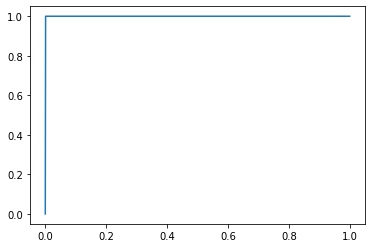

In [313]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
fig = plt.figure()
#ax = fig.gca(projection='3d')
plt.plot(_x[0], p0)
#fig.colorbar(surf, shrink=0.5, aspect=5)
#plt.show()

In [314]:
initial_condition = Dirichlet({'x': x,'t':t0}, {'p': p0.reshape(-1)}, device=device, name="initial")

In [315]:
p0.shape

(1000,)

In [316]:
pde.add_boco(initial_condition)
#p0=np.ones(len(y))
#p1=np.zeros(len(y))

In [317]:
pwf = PBC0({'x': np.array([0]),'t':t}, name='pwf', device=device)
#left = Dirichlet({'x': x, 'y': y}, {'p': p0.reshape(-1)}, device=device, name="left")

In [318]:
pde.add_boco(pwf)

In [319]:
#right = PBC0({'x': np.array([1]), 'y': y, 't':t}, name='right', device=device)
#right = Dirichlet({'x': x[-1], 'y': y}, {'p': p1.reshape(-1)}, device=device, name="right")
right =  NeumannX({'x': x[-1],'t':t}, name='right', device=device)

In [320]:
pde.add_boco(right)

In [343]:
#from nangs import MLP

BATCH_SIZE = 128
LR = 1e-2
EPOCHS = 250
NUM_LAYERS = 4
NUM_HIDDEN = 50

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, total_steps=EPOCHS)

In [344]:
mlp

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Sequential(
      (0): GELU()
      (1): Linear(in_features=50, out_features=50, bias=True)
    )
    (2): Sequential(
      (0): GELU()
      (1): Linear(in_features=50, out_features=50, bias=True)
    )
    (3): Sequential(
      (0): GELU()
      (1): Linear(in_features=50, out_features=50, bias=True)
    )
    (4): Sequential(
      (0): GELU()
      (1): Linear(in_features=50, out_features=1, bias=True)
    )
  )
)

In [345]:
pde.compile(mlp, optimizer, scheduler)

In [ ]:

%time hist = pde.solve(EPOCHS, BATCH_SIZE)

In [338]:
t = 0.0
x = np.linspace(0,1,100)
#y = np.linspace(0,1,100)

_x, _t = np.meshgrid(x, t)
eval_mesh = Mesh({'x': x,  't':t}, device=device)
p = pde.eval(eval_mesh)
p = p.cpu().numpy()
#p5 = p.reshape((_y.shape[0],_x.shape[1]))

In [341]:
ppp=[]
x = np.linspace(0.0,1,100)
for t in np.linspace(0.,1.,10):
  #_x,_t = np.meshgrid(x,t)
  eval_mesh = Mesh({'x': x,  't':t}, device=device)
  pp = pde.eval(eval_mesh)
  pp = pp.cpu().numpy()
  ppp.append(pp)

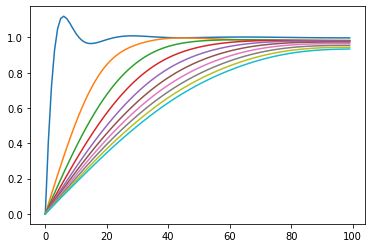

In [342]:
for p in ppp:
  plt.plot(p)

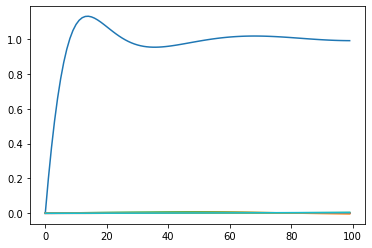

In [271]:
for p in ppp:
  plt.plot(p)

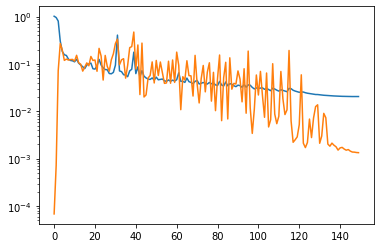

In [288]:
plt.plot(hist['initial'])
plt.plot(hist['pde'])
plt.yscale('log')

In [252]:
hist.keys()

dict_keys(['lr', 'initial', 'pwf_PWF', 'right_gradX', 'pde'])